In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import networkx as nx
from matplotlib import cm

plt.rcParams['text.usetex'] = True
jax.config.update("jax_enable_x64", True)
run_csv = pd.read_csv('loss_vs_iter.csv')

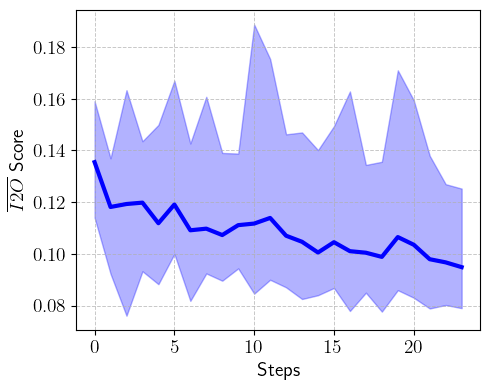

In [11]:
# Visualze Training Loss
# Remove the columns ends with _MAX or _MIN and remove Step column
run_csv = run_csv.loc[:,~run_csv.columns.str.endswith('_MAX')]
run_csv = run_csv.loc[:,~run_csv.columns.str.endswith('_MIN')]
run_csv = run_csv.loc[:,~run_csv.columns.str.endswith('Step')]

# X-axis: Steps
# Y-axis: Mean-Squared Error
# Title: Edge Detection
# Line: Mean and shaded area for the min/max

# Get the mean
mean = run_csv.mean(axis=1)

# Plot the mean and min/max values
steps = np.arange(0, len(mean))

# Plotting
plt.figure(figsize=(5, 4))  # Set a larger figure size
plt.plot(steps, mean, color='blue', linewidth=3)  # Thicker line

# Fill between min and max values
plt.fill_between(steps, run_csv.min(axis=1), run_csv.max(axis=1), color='blue', alpha=0.3)

# Enhancing aesthetics
# plt.title('Edge Detection', fontsize=18, fontweight='bold')  # Even larger, bold title
plt.xlabel('Steps', fontsize=14)  # Larger label font size
plt.ylabel(r'$\overline{I2O}$ Score', fontsize=14)  # Larger label font size

# Adjust tick size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a grid with a finer style
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Modify legend
# plt.legend(loc='upper right', fontsize=12, frameon=True, shadow=True)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.savefig('tln_loss_vs_iter.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# Visualize the coupling strength

def convert_weights(w: jnp.ndarray):
    # Weight consists of:
    # 1. 5 normalized capacitance +
    # 2. 4 normalized inductance +
    # 3. 8 normalized ws
    # 4. 8 normalized wt

    caps = w[:5]
    inds = w[5:9]
    ws = w[9:17]
    wt = w[17:]

    return caps, inds, ws, wt

# Create a figure with 3 subplots
# Init_weight, Fixed locking, Optimized locking

initial_weight = jnp.array([-0.81818182, -0.81818182, -0.81818182, -0.81818182, -0.81818182, -0.81818182, -0.81818182, -0.81818182, -0.81818182, -0.33333333, -0.33333333, -0.33333333, -0.33333333, -0.33333333, -0.33333333, -0.33333333, -0.33333333, -0.33333333, -0.33333333, -0.33333333, -0.33333333, -0.33333333, -0.33333333, -0.33333333, -0.33333333])
optimized_weight = jnp.array([-0.87481437, -0.79869999, -0.79574095, -0.78740942, -0.79168532, -0.87086579, -0.79396643, -0.80875292, -0.77703996, -0.27785575, -0.35021829, -0.35113954, -0.37357908, -0.33776242, -0.33675535, -0.37229164, -0.3593301,  -0.27785575, -0.35021829, -0.35113954, -0.37357908, -0.33776242, -0.33675535, -0.37229164, -0.3593301])


init_caps, init_inds, init_ws, init_wt = convert_weights(initial_weight)
opt_caps, opt_inds, opt_ws, opt_wt = convert_weights(optimized_weight)

print((opt_caps - init_caps) / init_caps)
print((opt_inds - init_inds) / init_inds)
print((opt_ws - init_ws) / init_ws)
print((opt_wt - init_wt) / init_wt)

[ 0.06921756 -0.02381113 -0.02742773 -0.03761071 -0.03238461]
[ 0.06439152 -0.02959659 -0.01152421 -0.0502845 ]
[-0.16643274  0.05065488  0.05341863  0.12073725  0.01328727  0.01026606
  0.11687493  0.07799031]
[-0.16643274  0.05065488  0.05341863  0.12073725  0.01328727  0.01026606
  0.11687493  0.07799031]


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

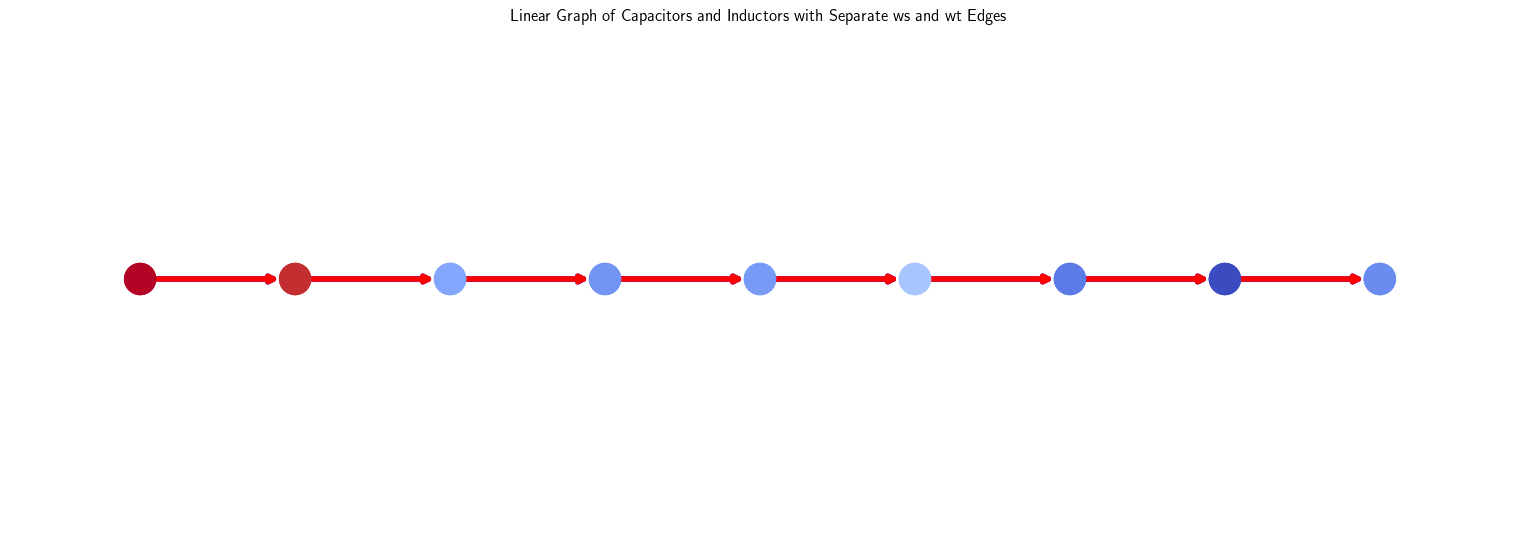

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

# Data
capacitance_vector = [0.06921756, -0.02381113, -0.02742773, -0.03761071, -0.03238461]
inductance_vector = [0.06439152, -0.02959659, -0.01152421, -0.0502845]
ws_vector = [-0.16643274, 0.05065488, 0.05341863, 0.12073725, 0.01328727, 0.01026606, 0.11687493, 0.07799031]
wt_vector = [-0.16643274, 0.05065488, 0.05341863, 0.12073725, 0.01328727, 0.01026606, 0.11687493, 0.07799031]

# Create a MultiDiGraph to allow multiple edges between the same nodes
G_multi = nx.MultiDiGraph()

# Add nodes for capacitors and inductors
for i, (c, l) in enumerate(zip(capacitance_vector, inductance_vector)):
    G_multi.add_node(f'C{i}', value=c)  # Capacitor node
    G_multi.add_node(f'L{i}', value=l)  # Inductor node

# Add the final capacitor node (since capacitors are one more than inductors)
G_multi.add_node(f'C{len(capacitance_vector) - 1}', value=capacitance_vector[-1])

# Add ws and wt edges between capacitors and inductors
for i in range(len(inductance_vector)):
    G_multi.add_edge(f'C{i}', f'L{i}', weight=ws_vector[2 * i], label='ws')
    G_multi.add_edge(f'C{i}', f'L{i}', weight=wt_vector[2 * i], label='wt')
    G_multi.add_edge(f'L{i}', f'C{i + 1}', weight=ws_vector[2 * i + 1], label='ws')
    G_multi.add_edge(f'L{i}', f'C{i + 1}', weight=wt_vector[2 * i + 1], label='wt')

# Prepare linear positions for nodes
pos_linear_multi = {f'C{i}': (2 * i, 0) for i in range(len(capacitance_vector))}
pos_linear_multi.update({f'L{i}': (2 * i + 1, 0) for i in range(len(inductance_vector))})

# Extract node values for coloring
node_values_multi = [G_multi.nodes[n]['value'] for n in G_multi.nodes]

# Draw the graph without labels, use different colors for ws and wt edges
plt.figure(figsize=(15, 5))

# Draw ws edges in one color and wt edges in another
edges_ws = [(u, v) for u, v, d in G_multi.edges(data=True) if d['label'] == 'ws']
edges_wt = [(u, v) for u, v, d in G_multi.edges(data=True) if d['label'] == 'wt']

nx.draw(G_multi, pos_linear_multi, with_labels=False, node_size=500, node_color=node_values_multi, cmap=plt.cm.coolwarm,
        edgelist=edges_ws, edge_color='blue', width=4, label='ws')
nx.draw(G_multi, pos_linear_multi, with_labels=False, node_size=500, node_color=node_values_multi, cmap=plt.cm.coolwarm,
        edgelist=edges_wt, edge_color='red', width=4, label='wt')

plt.title("Linear Graph of Capacitors and Inductors with Separate ws and wt Edges")
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.coolwarm), label="Node values (Capacitance/Inductance)")
plt.show()


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

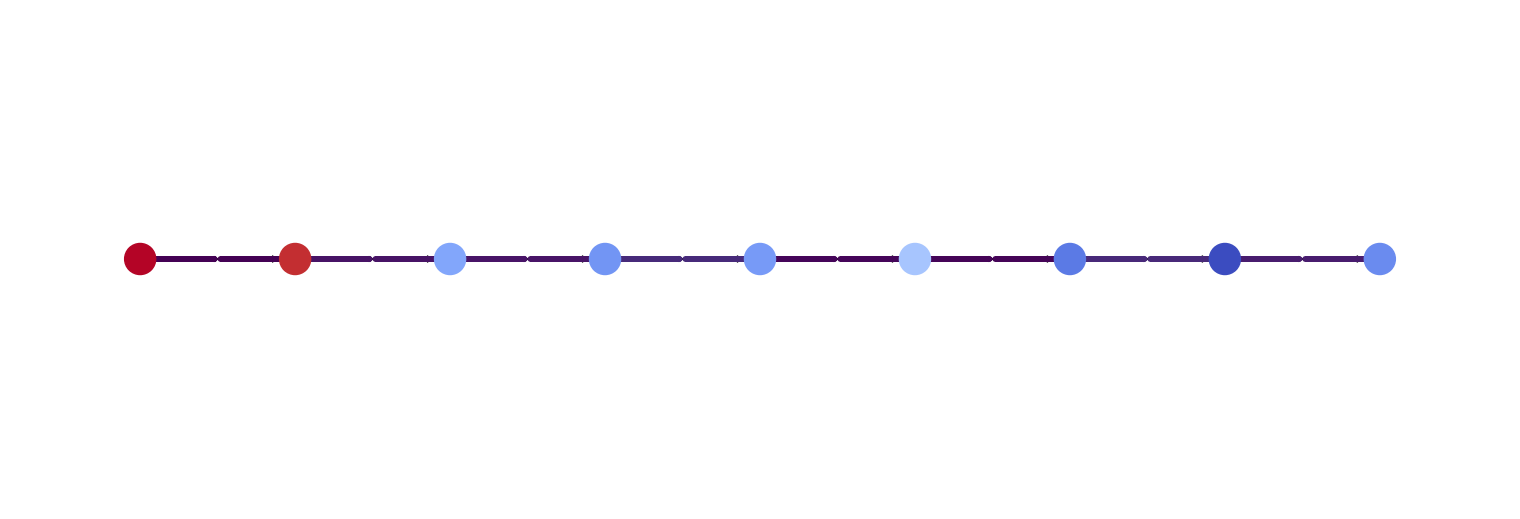

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Function to draw half-colored edges with custom edge colors from the ws and wt vectors
def draw_half_edges_colored(G, pos, ws_edges, wt_edges, ws_colors, wt_colors, edge_width=4):
    """
    Draw edges where the left half is colored with ws values and the right half with wt values.
    """
    ax = plt.gca()
    
    # Iterate over ws and wt edges and color them accordingly
    for (ws_edge, wt_edge), ws_color, wt_color in zip(zip(ws_edges, wt_edges), ws_colors, wt_colors):
        ws_line = [pos[ws_edge[0]], pos[ws_edge[1]]]
        wt_line = [pos[wt_edge[0]], pos[wt_edge[1]]]

        # Middle point between the two nodes
        mid_x = (ws_line[0][0] + ws_line[1][0]) / 2
        mid_y = (ws_line[0][1] + ws_line[1][1]) / 2

        # Draw left half (ws)
        left_ws_line = [ws_line[0], (mid_x, mid_y)]
        ax.add_patch(mpatches.FancyArrowPatch(left_ws_line[0], left_ws_line[1],
                                              color=plt.cm.viridis(ws_color), linewidth=edge_width,
                                              connectionstyle="arc3"))

        # Draw right half (wt)
        right_wt_line = [(mid_x, mid_y), ws_line[1]]
        ax.add_patch(mpatches.FancyArrowPatch(right_wt_line[0], right_wt_line[1],
                                              color=plt.cm.viridis(wt_color), linewidth=edge_width,
                                              connectionstyle="arc3"))

# Data and graph creation steps

# Create a new figure
plt.figure(figsize=(15, 5))

# Draw the graph nodes with capacitance and inductance values
nx.draw(G_multi, pos_linear_multi, with_labels=False, node_size=500, node_color=node_values_multi, cmap=plt.cm.coolwarm)

# Get the ws and wt edges
edges_ws = [(u, v) for u, v, d in G_multi.edges(data=True) if d['label'] == 'ws']
edges_wt = [(u, v) for u, v, d in G_multi.edges(data=True) if d['label'] == 'wt']

# Draw half-colored edges with colors based on ws and wt vectors
draw_half_edges_colored(G_multi, pos_linear_multi, edges_ws, edges_wt, 
                        ws_colors=ws_vector, wt_colors=wt_vector)

# Add a color bar for the nodes
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.coolwarm), label="Node values (Capacitance/Inductance)")
plt.title("Graph with Half-colored Edges Based on ws and wt Vectors")
plt.show()
